In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

class AnalizadorDatos:
    """
    Clase para el análisis de datos de un archivo .npy.
    Permite cargar los datos, dividirlos en entrenamiento y validación,
    calcular estadísticas descriptivas y generar histogramas con métricas.
    """

    def __init__(self, ruta_archivo):
        """
        Inicializa el analizador cargando los datos desde un archivo .npy.

        Parámetros:
        ruta_archivo (str): Ruta del archivo .npy con los datos.
        """
        self.ruta_archivo = ruta_archivo
        self.datos = None
        self.df = None
        self.entrenamiento = None
        self.validacion = None
        self.nombres_columnas = ["SalePrice", "OverallQual", "1stFlrSF", "TotRmsAbvGrd", "YearBuilt", "LotFrontage"]
        
        self.cargar_datos()
    
    def cargar_datos(self):
        """
        Carga los datos desde un archivo .npy, los convierte en un DataFrame de Pandas,
        y mezcla aleatoriamente las filas con una semilla fija para asegurar consistencia.
        """
        try:
            self.datos = np.load(self.ruta_archivo, allow_pickle=True)
            self.df = pd.DataFrame(self.datos, columns=self.nombres_columnas)

            # Mezclar las filas del DataFrame de forma reproducible
            self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)

            # Tratar valores faltantes en LotFrontage
            if "LotFrontage" in self.df.columns:
                mediana = self.df["LotFrontage"].median()
                self.df["LotFrontage"].fillna(mediana, inplace=True)

            print("Datos cargados y mezclados correctamente.")
        except Exception as e:
            print(f"Error al cargar los datos: {e}")

    def dividir_datos(self, proporcion_entrenamiento=0.8):
        """
        Divide los datos mezclados en entrenamiento y validación.

        Parámetros:
        proporcion_entrenamiento (float): Proporción de los datos a utilizar para entrenamiento. 
                                        Por defecto es 0.8 (80%).
        """
        tamano_entrenamiento = int(len(self.df) * proporcion_entrenamiento)
        self.entrenamiento = self.df.iloc[:tamano_entrenamiento, :].copy()
        self.validacion = self.df.iloc[tamano_entrenamiento:, :].copy()
        print(f"Datos divididos en {tamano_entrenamiento} registros para entrenamiento y {len(self.df) - tamano_entrenamiento} para validación.")

    def calcular_estadisticas(self):
        """
        Calcula estadísticas descriptivas sobre los datos de entrenamiento.

        Retorna:
        pd.DataFrame: Un DataFrame con las estadísticas de cada columna, incluyendo:
                      - Media
                      - Máximo
                      - Mínimo
                      - Rango (peak-to-peak)
                      - Desviación estándar
        """
        if self.entrenamiento is None:
            print("Primero ejecuta dividir_datos() antes de calcular estadísticas.")
            return None
        
        estadisticas = {
            "Media": np.mean(self.entrenamiento, axis=0),
            "Maximo": np.max(self.entrenamiento, axis=0),
            "Minimo": np.min(self.entrenamiento, axis=0),
            "Rango": np.ptp(self.entrenamiento, axis=0),  # Peak-to-peak (max - min)
            "DesviacionEstandar": np.std(self.entrenamiento, axis=0)
        }
        
        df_estadisticas = pd.DataFrame(estadisticas, index=self.nombres_columnas)
        return df_estadisticas
    
    def mostrar_cabecera(self, n=5):
        """
        Muestra las primeras 'n' filas del DataFrame.

        Parámetros:
        n (int): Número de filas a mostrar. Por defecto es 5.
        """
        print(self.df.head(n))

    def graficar_histogramas(self):
        """
        Genera histogramas para cada variable en el dataset, incluyendo:
        - Media (línea roja)
        - Mediana (línea azul)
        - Desviación estándar (líneas verdes en ±1σ)
        - Máximo y mínimo (marcadores)
        """
        for columna in self.nombres_columnas:
            datos = self.df[columna].dropna()  # Elimina valores nulos si los hay

            # Calcular estadísticas
            media = np.mean(datos)
            mediana = np.median(datos)
            desviacion = np.std(datos)
            minimo = np.min(datos)
            maximo = np.max(datos)

            # Crear histograma con seaborn
            plt.figure(figsize=(8, 5))
            sns.histplot(datos, kde=True, bins=30, color='lightseagreen')
            #lightseagreen, turquoise

            # Agregar líneas de estadísticas
            plt.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media:.2f}')
            plt.axvline(mediana, color='blue', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana:.2f}')
            plt.axvline(media - desviacion, color='red', linestyle='dotted', linewidth=2, label=f'-1σ: {(media - desviacion):.2f}')
            plt.axvline(media + desviacion, color='orange', linestyle='dotted', linewidth=2, label=f'+1σ: {(media + desviacion):.2f}')

            # Marcar mínimo y máximo
            plt.scatter([minimo, maximo], [0, 0], color='black', zorder=3, label=f'Mín: {minimo:.2f}, Máx: {maximo:.2f}')

            # Configuración del gráfico
            plt.title(f"Histograma de {columna}")
            plt.xlabel(columna)
            plt.ylabel("Frecuencia")
            plt.legend()
            plt.grid(True)
            plt.show()

    def analizar_correlaciones(self):
        """
        Calcula y grafica la correlación entre cada variable independiente y la variable dependiente 'SalePrice'.
        Muestra un scatterplot por variable con su coeficiente de correlación en el título.
        Al final imprime las 2 variables con mayor correlación con 'SalePrice'.
        """
        if self.df is None:
            print("No hay datos cargados.")
            return

        variable_objetivo = "SalePrice"
        variables_independientes = [col for col in self.nombres_columnas if col != variable_objetivo]
        correlaciones = {}

        for variable in variables_independientes:
            x = self.df[variable]
            y = self.df[variable_objetivo]

            # Calcular correlación
            coef = np.corrcoef(x, y)[0, 1]
            correlaciones[variable] = coef

            # Graficar
            plt.figure(figsize=(7, 5))
            plt.scatter(x, y, alpha=0.6)
            plt.title(f"{variable} vs {variable_objetivo} (Correlación: {coef:.4f})")
            plt.xlabel(variable)
            plt.ylabel(variable_objetivo)
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Ordenar correlaciones absolutas de mayor a menor
        correlaciones_ordenadas = sorted(correlaciones.items(), key=lambda item: abs(item[1]), reverse=True)

        print("Variables con mayor correlación con SalePrice:")
        for variable, coef in correlaciones_ordenadas[:2]:
            print(f"{variable}: {coef:.4f}")
            
    def graficar_matriz_correlacion_personalizada(self):
        """
        Genera una matriz de correlación personalizada:
        - Parte inferior: scatterplots.
        - Parte superior: coeficiente de correlación (Pearson).
        - Solo se usan seaborn, matplotlib, numpy, pandas.
        """
        # Definir dimensiones
        columnas = self.df.columns
        num_vars = len(columnas)

        # Crear PairGrid
        grid = sns.PairGrid(self.df, vars=columnas, diag_sharey=False)

        # Parte inferior: scatterplot
        grid.map_lower(sns.scatterplot, s=10, alpha=0.6)

        # Parte superior: texto con coeficiente de correlación
        def correlacion(x, y, **kwargs):
            r = np.corrcoef(x, y)[0, 1]
            ax = plt.gca()
            ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                        ha='center', va='center', fontsize=12)

        grid.map_upper(correlacion)

        # Diagonal: histogramas
        grid.map_diag(sns.histplot, kde=True)

        plt.tight_layout()
        plt.show()
        
    def entrenar_modelo_lineal_simple(self, x, y, epochs, imprimir_error_cada, alpha):
        """
        Entrena un modelo de regresión lineal simple y = β0 + β1 * x utilizando descenso por gradiente.

        Parámetros:
        x (np.ndarray): Variable independiente (6.1)
        y (np.ndarray): Variable dependiente (6.2)
        epochs (int): Número de iteraciones de entrenamiento (6.3)
        imprimir_error_cada (int): Frecuencia de impresión del error (6.4)
        alpha (float): Tasa de aprendizaje (6.5)

        Retorna:
        tuple: β0 (intercepto), β1 (pendiente)
        """
        n = len(x)

        # Inicialización de parámetros
        beta_0 = 0
        beta_1 = 0

        for epoch in range(1, epochs + 1):

            # 6.1 y 6.2: cálculo de predicciones usando x e y
            y_pred = beta_0 + beta_1 * x

            # Cálculo del error
            error = y - y_pred

            # Gradientes para descenso por gradiente
            grad_b0 = (-2 / n) * np.sum(error)
            grad_b1 = (-2 / n) * np.sum(error * x)

            # 6.5: actualización de parámetros usando alpha
            beta_0 -= alpha * grad_b0
            beta_1 -= alpha * grad_b1

            # 6.4: imprimir error cada cierto número de iteraciones
            if epoch % imprimir_error_cada == 0:
                mse = np.mean(error**2)
                print(f"Iteración {epoch} - Error (RMSE): {np.sqrt(mse):.4f}, beta_0: {(beta_0):.4f}, beta_1: {(beta_1):.4f}  ")

            self.beta_0 = beta_0
            self.beta_1 = beta_1

        return beta_0, beta_1
    
    def construir_matriz_entrada(self, variable_independiente, variable_dependiente, conjunto='entrenamiento'):
        """
        Parte del ejercicio: 7 (primera viñeta)

        Crea la matriz de entrada X extendida (con columna de unos) y el vector y correspondiente.

        Permite aplicar regresión lineal como un producto matricial:
        \n
        y_hat = X @ parametros

        Donde X es una matriz de shape (n, 2): [x, 1], y `parametros = [b1, b0]`

        Parámetros:
        variable_independiente (str): Nombre de la columna a usar como X.
        variable_dependiente (str): Nombre de la columna a usar como y.
        conjunto (str): Indica si se usa 'entrenamiento', 'validacion' o 'completo'. Por defecto es 'entrenamiento'.

        Retorna:
        tuple: (X, y)
            X: np.ndarray de shape (n, 2), con la variable independiente y una columna de unos
            y: np.ndarray de shape (n,), con la variable dependiente
        """
        if conjunto == 'entrenamiento':
            df = self.entrenamiento
        elif conjunto == 'validacion':
            df = self.validacion
        elif conjunto == 'completo':
            df = self.df
        else:
            raise ValueError("El conjunto debe ser 'entrenamiento', 'validacion' o 'completo'.")

        x = df[variable_independiente].to_numpy().reshape(-1, 1)
        unos = np.ones_like(x)
        X = np.hstack([x, unos])  # columna 1 = x, columna 2 = unos
        y = df[variable_dependiente].to_numpy()
        return X, y

    def entrenar_vectorizado(self, X, y, epochs, alpha, imprimir_error_cada=1000):
        """
        Entrena un modelo de regresión lineal simple usando descenso por gradiente vectorizado.

        Parámetros:
        X (np.ndarray): Matriz extendida de entrada con forma (n, 2)
        y (np.ndarray): Vector de salida (n,)
        epochs (int): Número total de iteraciones
        alpha (float): Tasa de aprendizaje
        imprimir_error_cada (int): Frecuencia de impresión del error

        Retorna:
        tuple: 
            historial_parametros (dict): {iteración: vector parámetros [β1, β0]}
            errores (list): lista de errores (RMSE) por iteración
        """
        n = len(y)

        # Inicializar parámetros [β1, β0]
        parametros = np.zeros(2)

        historial_parametros = {}
        errores = []

        for epoch in range(1, epochs + 1):
            # Predicción vectorizada: ŷ = X @ θ
            y_pred = X @ parametros

            # Error (MSE dividido entre 2 por convención matemática)
            error = y - y_pred
            mse = np.mean(error ** 2) / 2
            rmse = np.sqrt(2 * mse)
            errores.append(rmse)

            # Gradiente vectorizado
            gradiente = (1 / n) * X.T @ error

            # Actualización
            parametros -= alpha * gradiente

            # Guardar parámetros cada cierto tiempo
            if epoch % imprimir_error_cada == 0:
                historial_parametros[epoch] = parametros.copy()
                print(f"Iteración {epoch} - Error (RMSE): {rmse:.2f} - Parámetros: {parametros}")

        # Guardar los últimos coeficientes como atributos
        self.beta_1_vectorizado = parametros[0]
        self.beta_0_vectorizado = parametros[1]

        return historial_parametros, errores

    def entrenar_vectorizado_estandarizado(self, X, y, epochs, alpha, imprimir_error_cada=1000):
        """
        Entrena un modelo de regresión lineal simple con descenso por gradiente vectorizado,
        usando z-score para estandarizar X e Y.

        Parámetros:
        X (np.ndarray): Matriz (n, 2) con columna de x y columna de unos
        y (np.ndarray): Vector de salida (n,)
        epochs (int): Número de iteraciones
        alpha (float): Tasa de aprendizaje
        imprimir_error_cada (int): Frecuencia de impresión

        Retorna:
        tuple: (historial_parametros, errores)
        """
        n = len(y)

        # Extraer columna x (la primera)
        x_original = X[:, 0].copy()

        # Calcular medias y desviaciones
        media_x = np.mean(x_original)
        desv_x = np.std(x_original)
        media_y = np.mean(y)
        desv_y = np.std(y)

        # Guardar para desestandarizar más adelante
        self.media_x = media_x
        self.desv_x = desv_x
        self.media_y = media_y
        self.desv_y = desv_y

        # Estandarizar x y y
        x_norm = (x_original - media_x) / desv_x
        y_norm = (y - media_y) / desv_y

        # Reconstruir X con columna de unos
        X_norm = np.column_stack([x_norm, np.ones_like(x_norm)])

        # Inicializar parámetros
        parametros = np.zeros(2)
        historial_parametros = {}
        errores = []

        for epoch in range(1, epochs + 1):
            y_pred = X_norm @ parametros
            error = y_pred - y_norm  # Cambio importante de signo
            mse = np.mean(error ** 2) / 2
            rmse = np.sqrt(2 * mse)
            errores.append(rmse)

            gradiente = (1 / n) * X_norm.T @ error
            parametros -= alpha * gradiente

            if imprimir_error_cada > 0 and epoch % imprimir_error_cada == 0:
                historial_parametros[epoch] = parametros.copy()
                print(f"Iteración {epoch} - Error (RMSE): {rmse:.4f}")
                print(f"   Beta 1 (pendiente estandarizada): {parametros[0]:.4f}")
                print(f"   Beta 0 (intercepto estandarizado): {parametros[1]:.4f}")

        # Guardar los últimos parámetros aprendidos
        self.beta_1_estandarizado = parametros[0]
        self.beta_0_estandarizado = parametros[1]

        return historial_parametros, errores

    def graficar_curva_error(self, errores):
        """
        Grafica la evolución del error (RMSE) durante el entrenamiento del modelo vectorizado.

        Parámetros:
        errores (list): Lista con los valores del error (RMSE) por iteración.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(errores) + 1), errores, linewidth=2)
        plt.title("Curva de Error durante el Entrenamiento")
        plt.xlabel("Iteración")
        plt.ylabel("Error (RMSE)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def graficar_modelos(self, historial_parametros, X_original, y_original, cada_n=1000):
        """
        Grafica la evolución del modelo (rectas de regresión) cada 'n' iteraciones,
        destacando con colores más fuertes las rectas a partir de la iteración 25000.

        Parámetros:
        historial_parametros (dict): Diccionario con los parámetros por iteración {iter: [beta_1, beta_0]}
        X_original (np.ndarray): Matriz de entrada original (sin estandarizar), con columna x y columna de unos
        y_original (np.ndarray): Vector de salida original (sin estandarizar)
        cada_n (int): Intervalo de iteraciones a graficar
        """
        x = X_original[:, 0]
        plt.figure(figsize=(8, 5))
        plt.scatter(x, y_original, alpha=0.5, label="Datos reales")

        x_min, x_max = np.min(x), np.max(x)
        x_linea = np.linspace(x_min, x_max, 100)

        for iteracion, parametros in historial_parametros.items():
            beta_1_z, beta_0_z = parametros
            beta_1_real = (self.desv_y / self.desv_x) * beta_1_z
            beta_0_real = self.media_y + self.desv_y * beta_0_z - beta_1_real * self.media_x
            y_linea = beta_0_real + beta_1_real * x_linea

            if iteracion < 25000:
                plt.plot(x_linea, y_linea, alpha=0.4, linewidth=1.0, linestyle='--', label=f"{iteracion} iter.")
            else:
                plt.plot(x_linea, y_linea, alpha=0.9, linewidth=2.5, label=f"{iteracion} iter. (final)")

        plt.xlabel("OverallQual")
        plt.ylabel("SalePrice")
        plt.title("Evolución del modelo durante el entrenamiento")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def entrenar_modelo_sklearn(self, x, y):
        """
        Entrena un modelo de regresión lineal utilizando scikit-learn.

        Parámetros:
        x (np.ndarray): Variable independiente (vector 1D)
        y (np.ndarray): Variable dependiente (vector 1D)

        Retorna:
        modelo_entrenado (LinearRegression): Objeto entrenado de sklearn
        """
        modelo = LinearRegression()
        x_reshaped = x.reshape(-1, 1)
        modelo.fit(x_reshaped, y)

        self.modelo_sklearn = modelo
        self.coeficiente_sklearn = modelo.coef_[0]
        self.intercepto_sklearn = modelo.intercept_

        print("Modelo sklearn entrenado correctamente.")
        print(f"   Beta 1 (pendiente): {self.coeficiente_sklearn:.4f}")
        print(f"   Beta 0 (intercepto): {self.intercepto_sklearn:.4f}")

        return modelo

    def predecir_comparacion_modelos(self, x_valores):
        """
        Recibe un array de valores de x (OverallQual) y devuelve:
        - Predicción usando el modelo vectorizado estandarizado
        - Predicción usando el modelo sklearn
        - Promedio de ambas predicciones
        También imprime la fórmula de cada modelo (pendiente e intercepto).

        Parámetros:
        x_valores (np.ndarray o list): Valores de OverallQual para predecir

        Retorna:
        dict: {
            'modelo_propio': np.ndarray,
            'modelo_sklearn': np.ndarray,
            'promedio': np.ndarray
        }
        """
        x_valores = np.array(x_valores).reshape(-1)

        # Verificar que se entrenó el modelo propio y sklearn
        if not hasattr(self, "beta_1_estandarizado") or not hasattr(self, "modelo_sklearn"):
            print("Falta entrenar alguno de los modelos.")
            return None

        # ------- Modelo propio (vectorizado estandarizado) -------
        x_norm = (x_valores - self.media_x) / self.desv_x
        y_norm_pred = self.beta_0_estandarizado + self.beta_1_estandarizado * x_norm
        y_pred_propio = y_norm_pred * self.desv_y + self.media_y  # Desescalar

        # Calcular fórmula del modelo propio en escala original
        beta_1_real = (self.desv_y / self.desv_x) * self.beta_1_estandarizado
        beta_0_real = self.media_y + self.desv_y * self.beta_0_estandarizado - beta_1_real * self.media_x

        print("\nModelo propio (vectorizado):")
        print(f"   y = {beta_0_real:.4f} + {beta_1_real:.4f} * x")

        # ------- Modelo sklearn -------
        x_input = x_valores.reshape(-1, 1)
        y_pred_sklearn = self.modelo_sklearn.predict(x_input)

        print("\nModelo sklearn:")
        print(f"   y = {self.intercepto_sklearn:.4f} + {self.coeficiente_sklearn:.4f} * x")

        # ------- Promedio -------
        y_promedio = (y_pred_propio + y_pred_sklearn) / 2

        # ------- Retorno -------
        return {
            "modelo_propio": y_pred_propio,
            "modelo_sklearn": y_pred_sklearn,
            "promedio": y_promedio
        }
    
    def validar_modelos(self):
        """
        Valida ambos modelos (propio vectorizado y sklearn) usando el conjunto de validación.
        Calcula el RMSE de cada uno y muestra cuál generaliza mejor.
        """
        if self.validacion is None or self.entrenamiento is None:
            print("Primero debes dividir los datos usando dividir_datos().")
            return

        if not hasattr(self, "beta_1_estandarizado") or not hasattr(self, "modelo_sklearn"):
            print("Asegúrate de haber entrenado ambos modelos antes de validar.")
            return

        # Validación sobre OverallQual → SalePrice
        x_val = self.validacion["OverallQual"].to_numpy()
        y_val_real = self.validacion["SalePrice"].to_numpy()

        # --- Modelo propio ---
        x_val_norm = (x_val - self.media_x) / self.desv_x
        y_norm_pred = self.beta_0_estandarizado + self.beta_1_estandarizado * x_val_norm
        y_pred_propio = y_norm_pred * self.desv_y + self.media_y

        rmse_propio = np.sqrt(np.mean((y_val_real - y_pred_propio) ** 2))

        # --- Modelo sklearn ---
        x_input = x_val.reshape(-1, 1)
        y_pred_sklearn = self.modelo_sklearn.predict(x_input)

        rmse_sklearn = np.sqrt(np.mean((y_val_real - y_pred_sklearn) ** 2))

        # --- Mostrar resultados ---
        print("VALIDACIÓN CONJUNTO 20%")
        print(f"  RMSE modelo propio: {rmse_propio:.2f}")
        print(f"  RMSE modelo sklearn: {rmse_sklearn:.2f}")

        if rmse_propio < rmse_sklearn:
            print("✅ El modelo propio generaliza mejor.")
        elif rmse_sklearn < rmse_propio:
            print("✅ El modelo sklearn generaliza mejor.")
        else:
            print("⚖️ Ambos modelos tienen el mismo rendimiento.")

        return rmse_propio, rmse_sklearn

    def analizar_predicciones_validacion(self):
        """
        Muestra, grafica y analiza las predicciones de ambos modelos sobre el conjunto de validación.
        Incluye comparaciones visuales, errores por índice, R² y tabla de valores reales vs predichos.
        """
        if self.validacion is None:
            print("Primero debes dividir los datos.")
            return

        if not hasattr(self, "beta_1_estandarizado") or not hasattr(self, "modelo_sklearn"):
            print("Falta entrenar los modelos.")
            return

        x_val = self.validacion["OverallQual"].to_numpy()
        y_val_real = self.validacion["SalePrice"].to_numpy()

        # --- Modelo propio ---
        x_val_norm = (x_val - self.media_x) / self.desv_x
        y_norm_pred = self.beta_0_estandarizado + self.beta_1_estandarizado * x_val_norm
        y_pred_propio = y_norm_pred * self.desv_y + self.media_y

        # --- Modelo sklearn ---
        y_pred_sklearn = self.modelo_sklearn.predict(x_val.reshape(-1, 1))

        # --- R² ---
        r2_propio = r2_score(y_val_real, y_pred_propio)
        r2_sklearn = r2_score(y_val_real, y_pred_sklearn)

        # --- Errores individuales ---
        error_propio = np.abs(y_val_real - y_pred_propio)
        error_sklearn = np.abs(y_val_real - y_pred_sklearn)

        # --- Mostrar tabla resumida ---
        print("Índice | Real | Propio | Sklearn | Error propio | Error sklearn")
        for i in range(len(y_val_real)):
            print(f"{i:6} | {y_val_real[i]:7.0f} | {y_pred_propio[i]:7.0f} | {y_pred_sklearn[i]:8.0f} | {error_propio[i]:12.2f} | {error_sklearn[i]:14.2f}")

        # --- Gráfico 1: Valores reales vs predichos ---
        plt.figure(figsize=(10, 5))
        plt.plot(y_val_real, label="Valor real", color='blue', linewidth=2)
        plt.plot(y_pred_propio, label="Predicción propio", color='red', linestyle='-')
        plt.plot(y_pred_sklearn, label="Predicción sklearn", color='green', linestyle='--')    
        plt.title("Comparación: Valor real vs Predicciones")
        plt.xlabel("Índice")
        plt.ylabel("SalePrice")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Gráfico 2: Error absoluto ---
        plt.figure(figsize=(10, 5))
        plt.plot(error_propio, label="Error modelo propio", color='blue')
        plt.plot(error_sklearn, label="Error modelo sklearn", color='orange')
        plt.title("Error Absoluto por Predicción")
        plt.xlabel("Índice")
        plt.ylabel("Error absoluto")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Mostrar métricas globales ---
        print(f"\nR² modelo propio: {r2_propio:.4f}")
        print(f"R² modelo sklearn: {r2_sklearn:.4f}")


In [42]:
# ---------- DEFINICION Y USO DE LA CLASE ----------
if __name__ == "__main__":
    # Crear una instancia de la clase
    ruta_archivo = r"C:\PythonWs\Proyecto\proyecto_training_data.npy"
    analizador = AnalizadorDatos(ruta_archivo)

    # Mostrar las primeras filas
    #analizador.mostrar_cabecera(10)

    # Separar los datos en entrenamiento y validación
    analizador.dividir_datos()

Datos cargados y mezclados correctamente.
Datos divididos en 1168 registros para entrenamiento y 292 para validación.


C:\Users\EC\AppData\Local\Temp\ipykernel_22204\2061744383.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df["LotFrontage"].fillna(mediana, inplace=True)


In [12]:

# Calcular y mostrar estadísticas descriptivas
estadisticas = analizador.calcular_estadisticas()
print(estadisticas)

                      Media    Maximo   Minimo     Rango  DesviacionEstandar
SalePrice     181081.876712  755000.0  34900.0  720100.0        81096.489736
OverallQual        6.095034      10.0      1.0       9.0            1.402802
1stFlrSF        1161.268836    4692.0    334.0    4358.0          393.372616
TotRmsAbvGrd       6.532534      14.0      2.0      12.0            1.626715
YearBuilt       1971.120719    2009.0   1872.0     137.0           30.266595
LotFrontage       70.049658     313.0     21.0     292.0           22.723041


In [ ]:
analizador.graficar_histogramas()

In [ ]:
# 5. Para cada variable independiente x :
analizador.analizar_correlaciones()

In [ ]:
# Si ya tienes tu dataframe dentro de la clase, fuera puedes hacer:
analizador.graficar_matriz_correlacion_personalizada()


## Variables seleccionadas 
# Variable dependiente = SalePrice
# Variable independiente 1 = OverallQual: (Coeficiente de correlacion 0.7910) 

In [29]:
#6.1 Vector con la variable independiente x,
x = analizador.entrenamiento["OverallQual"].to_numpy()

#6.2 Vector con la variable dependiente y,
y = analizador.entrenamiento["SalePrice"].to_numpy()

beta_0, beta_1 = analizador.entrenar_modelo_lineal_simple(x, y, 1000, 100, 0.0001)
print(f"Modelo entrenado: y = {beta_0:.2f} + {beta_1:.2f} * x")


Iteración 100 - Error (RMSE): 101846.1305, beta_0: 2466.6530, beta_1: 16474.3968  
Iteración 200 - Error (RMSE): 66732.9900, beta_0: 3514.1539, beta_1: 23851.6069  
Iteración 300 - Error (RMSE): 57168.9531, beta_0: 3926.9647, beta_1: 27159.9057  
Iteración 400 - Error (RMSE): 55049.0398, beta_0: 4055.9520, beta_1: 28648.2921  
Iteración 500 - Error (RMSE): 54607.4743, beta_0: 4058.0482, beta_1: 29322.6769  
Iteración 600 - Error (RMSE): 54511.1123, beta_0: 4003.4443, beta_1: 29632.9744  
Iteración 700 - Error (RMSE): 54484.2285, beta_0: 3923.5346, beta_1: 29780.4178  
Iteración 800 - Error (RMSE): 54471.2758, beta_0: 3832.3609, beta_1: 29855.0129  
Iteración 900 - Error (RMSE): 54461.1247, beta_0: 3736.2035, beta_1: 29897.0166  
Iteración 1000 - Error (RMSE): 54451.5478, beta_0: 3637.8714, beta_1: 29924.4347  
Modelo entrenado: y = 3637.87 + 29924.43 * x


## Ejercicio 7

In [43]:
#   Crear una matriz de 2 columnas, la primera columna corresponde al vector de datos x
# y la segunda columna de la matriz para todas las filas es igual a 1.
X, y = analizador.construir_matriz_entrada("OverallQual", "SalePrice", conjunto="entrenamiento")
print(X[:5])  # Debería mostrar: [[x, 1], [x, 1], ...]
print(y[:5])  # Primeros 5 valores de y


[[6. 1.]
 [8. 1.]
 [5. 1.]
 [6. 1.]
 [9. 1.]]
[154500. 325000. 115000. 159000. 315500.]


In [ ]:
#No estandarizado 
X_novect, y_novect = analizador.construir_matriz_entrada("OverallQual", "SalePrice")
historial_novect, errores_novect = analizador.entrenar_vectorizado(X_novect, y_novect, epochs=10000, alpha=0.0001, imprimir_error_cada=1000)


Iteración 1000 - Error (RMSE): 10361775.86 - Parámetros: [-1594141.61960425  -248183.19965617]
Iteración 2000 - Error (RMSE): 565054415.58 - Parámetros: [-88523777.92131202 -13809570.05856965]
Iteración 3000 - Error (RMSE): 30814304974.46 - Parámetros: [-4.82908302e+09 -7.53384565e+08]
Iteración 4000 - Error (RMSE): 1680407000297.74 - Parámetros: [-2.63347612e+11 -4.10849074e+10]
Iteración 5000 - Error (RMSE): 91638207936025.31 - Parámetros: [-1.43612267e+13 -2.24049762e+12]
Iteración 6000 - Error (RMSE): 4997337640368282.00 - Parámetros: [-7.83165676e+14 -1.22181821e+14]
Iteración 7000 - Error (RMSE): 272521517545127584.00 - Parámetros: [-4.27086408e+16 -6.66298291e+15]
Iteración 8000 - Error (RMSE): 14861508841260937216.00 - Parámetros: [-2.32904487e+18 -3.63354719e+17]
Iteración 9000 - Error (RMSE): 810447729149695492096.00 - Parámetros: [-1.27010598e+20 -1.98149468e+19]
Iteración 10000 - Error (RMSE): 44196422361928039399424.00 - Parámetros: [-6.92631226e+21 -1.08057525e+21]


In [44]:
#Estandarizado
X, y = analizador.construir_matriz_entrada("OverallQual", "SalePrice", conjunto="entrenamiento")
historial, errores = analizador.entrenar_vectorizado_estandarizado(X, y, epochs=40000, alpha=0.0001, imprimir_error_cada=8000)


Iteración 8000 - Error (RMSE): 0.7059
   Beta 1 (pendiente estandarizada): 0.4366
   Beta 0 (intercepto estandarizado): 0.0000
Iteración 16000 - Error (RMSE): 0.6301
   Beta 1 (pendiente estandarizada): 0.6328
   Beta 0 (intercepto estandarizado): 0.0000
Iteración 24000 - Error (RMSE): 0.6136
   Beta 1 (pendiente estandarizada): 0.7210
   Beta 0 (intercepto estandarizado): 0.0000
Iteración 32000 - Error (RMSE): 0.6102
   Beta 1 (pendiente estandarizada): 0.7606
   Beta 0 (intercepto estandarizado): 0.0000
Iteración 40000 - Error (RMSE): 0.6096
   Beta 1 (pendiente estandarizada): 0.7784
   Beta 0 (intercepto estandarizado): 0.0000


Crear una funci´on que nos permita visualizar con matplotlib c´omo cambia el error en
el tiempo: crear una funci´on que tome como par´ametro el vector de errores generados
por la funci´on de entrenamiento y grafique en el eje x el nu´mero de iteraci´on y en
el eje y el error para esa iteraci´on

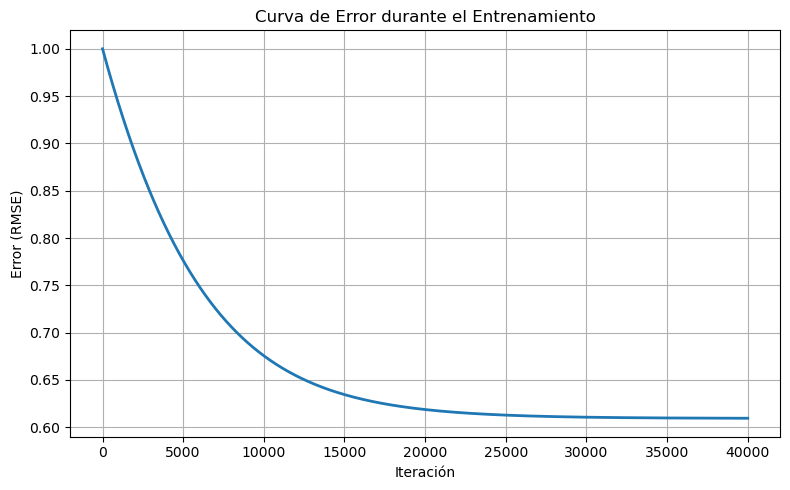

In [14]:
analizador.graficar_curva_error(errores)

Crear una funci´on que nos permita visualizar con matplotlib c´omo evoluciona el
modelo entrenado en el tiempo : Crear una funci´on que tome como par´ametro la
estructura de datos conteniendo el historial de modelos ,y un valor ?n? que indica
cada cuantas iteraciones graficar el modelo resultante, por ejemplo para n=3 la
funci´on debe graficar la recta correspondiente al modelo junto a los datos cada 3
iteraciones, si se ejecutaron 15 iteraciones , para n = 3 se grafica el modelo de las
iteraciones 3,6,9,12,15 junto con los datos de entrenamiento.

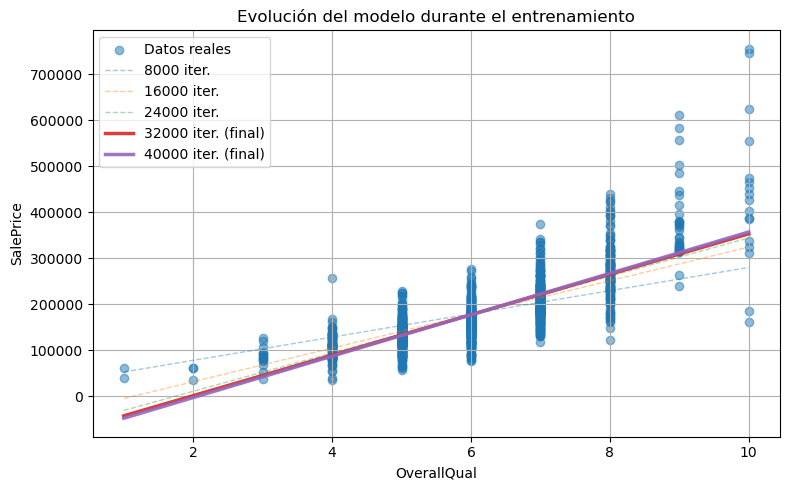

In [45]:
analizador.graficar_modelos(historial, X, y, cada_n=1500)

In [46]:
x_vector = X[:, 0]  # Solo la columna de OverallQual, sin la de unos

modelo = analizador.entrenar_modelo_sklearn(x_vector, y)

Modelo sklearn entrenado correctamente.
   Beta 1 (pendiente): 45836.2295
   Beta 0 (intercepto): -98291.5120


• Para cada variable independiente x elegida, crear una funci´on que usando el modelo
entrenado manualmente y el modelo de scikit-learn(enviados como par´ametros a la
4
Proyecto #1 − Ciencia de Datos en Python
funci´on) calcule la estimaci´on o predicci´on de cada uno de estos y devuelva como
resultado una predicci´on estimada promediando las predicciones de los 2 modelos,
la funci´on debe recibir como par´ametro adicional un vector de cualquier taman˜o de
x y devolver 3 vectores cada uno del mismo taman˜o del vector x, estos vectores son:
◦ La predicci´on con el modelo entrenado manualmente
◦ La predicci´on con el modelo de scikit-learn
◦ La combinaci´on(promedio) de las 2 anteriores.

In [47]:
valores_test = [3, 5, 7, 9]
resultados = analizador.predecir_comparacion_modelos(valores_test)

print("Predicciones del modelo propio:", resultados["modelo_propio"])
print("Predicciones de sklearn:", resultados["modelo_sklearn"])
print("Promedio:", resultados["promedio"])



Modelo propio (vectorizado):
   y = -93175.6332 + 44996.8776 * x

Modelo sklearn:
   y = -98291.5120 + 45836.2295 * x
Predicciones del modelo propio: [ 41814.99957561 131808.75475995 221802.50994428 311796.26512862]
Predicciones de sklearn: [ 39217.17660865 130889.63565213 222562.09469562 314234.5537391 ]
Promedio: [ 40516.08809213 131349.19520604 222182.30231995 313015.40943386]


In [48]:
analizador.validar_modelos()

VALIDACIÓN CONJUNTO 20%
  RMSE modelo propio: 45083.73
  RMSE modelo sklearn: 45141.91
✅ El modelo propio generaliza mejor.


(np.float64(45083.72621867062), np.float64(45141.90750638132))

Índice | Real | Propio | Sklearn | Error propio | Error sklearn
     0 |  210000 |  176806 |   176726 |     33194.37 |       33274.13
     1 |   97500 |  176806 |   176726 |     79305.63 |       79225.87
     2 |  165000 |  176806 |   176726 |     11805.63 |       11725.87
     3 |  213490 |  221803 |   222562 |      8312.51 |        9072.09
     4 |  137900 |  131809 |   130890 |      6091.25 |        7010.36
     5 |  155000 |  221803 |   222562 |     66802.51 |       67562.09
     6 |  466500 |  356793 |   360071 |    109706.86 |      106429.22
     7 |  244600 |  266799 |   268398 |     22199.39 |       23798.32
     8 |  110000 |  131809 |   130890 |     21808.75 |       20889.64
     9 |  112000 |  131809 |   130890 |     19808.75 |       18889.64
    10 |  134800 |  131809 |   130890 |      2991.25 |        3910.36
    11 |  119000 |  176806 |   176726 |     57805.63 |       57725.87
    12 |  223000 |  176806 |   176726 |     46194.37 |       46274.13
    13 |  192500 |  221803

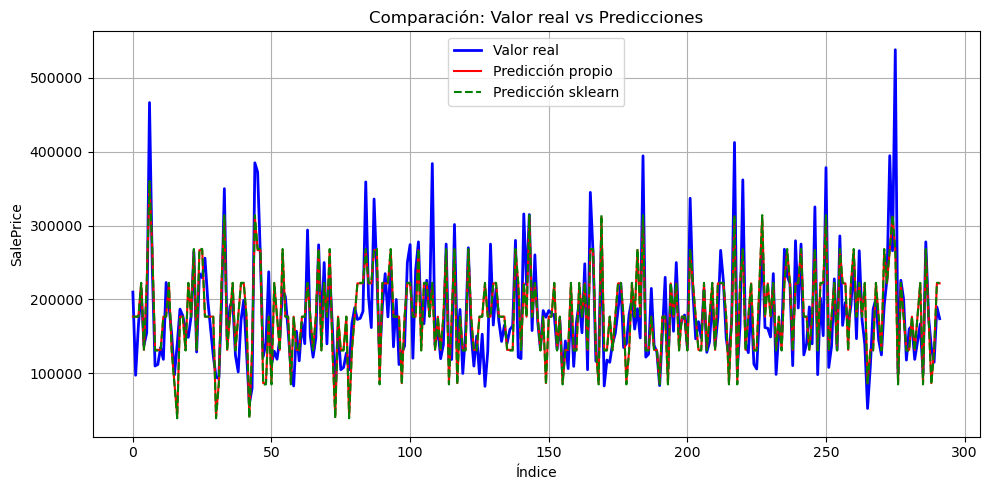

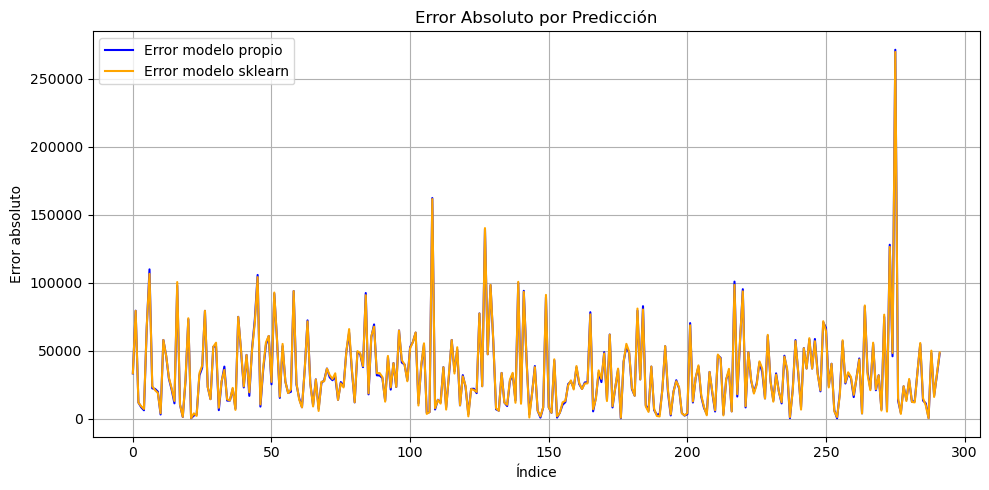


R² modelo propio: 0.6111
R² modelo sklearn: 0.6101


In [49]:
analizador.analizar_predicciones_validacion()